In [102]:
import pymongo
import seaborn as sns
%matplotlib inline

In [4]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [5]:
client = pymongo.MongoClient()
db = client.metrics

cb_td, cb_vd, sc_td, sc_vd = "CB_TAGGING_TD_FEAT_SELECTION", "CB_TAGGING_VD_FEAT_SELECTION", "SC_TAGGING_TD_FEAT_SELECTION", "SC_TAGGING_VD_FEAT_SELECTION"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_VD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_VD_FEAT_SELECTION'))

# Query Top Features

In [6]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score": "$MICRO_F1.f1_score",
            "window_size":    "$parameters.window_size",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

In [7]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(10)

,_id,asof,count,feats,micro_f1_score,weighted_f1_score,window_size,hs_feats
0,58049679c1a7cb44222ddd3b,2016-10-17 04:14:33.083,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.828318,0.822510,11,extract_brown_cluster|extract_dependency_relat...
1,5804e5d8c1a7cb44222dddc1,2016-10-17 09:53:12.950,6,"[fn_pos_wd_feats_stemmed[offset:6], fn_pos_ngr...",0.827998,0.821827,13,extract_brown_cluster|extract_dependency_relat...
2,580445e4c1a7cb44222ddcbd,2016-10-16 22:30:44.677,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827891,0.822128,9,extract_brown_cluster|extract_dependency_relat...
3,58044d32c1a7cb44222ddcc3,2016-10-16 23:01:54.576,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827796,0.821831,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
4,5804358ec1a7cb44222ddcad,2016-10-16 21:21:02.512,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827714,0.821858,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
5,580490c2c1a7cb44222ddd35,2016-10-17 03:50:10.217,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827713,0.821803,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
6,5804e24dc1a7cb44222dddbd,2016-10-17 09:38:05.614,6,"[fn_pos_wd_feats_stemmed[offset:6], fn_pos_ngr...",0.827645,0.821416,13,extract_brown_cluster|extract_dependency_relat...
7,5804871cc1a7cb44222ddd2b,2016-10-17 03:09:00.384,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827558,0.821638,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
8,58043dd9c1a7cb44222ddcb7,2016-10-16 21:56:25.404,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827528,0.821848,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
9,580492f6c1a7cb44222ddd37,2016-10-17 03:59:34.101,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827457,0.821547,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...


In [19]:
cols = "feats,count,micro_f1_score,window_size".split(",")
def get_top_individual_feats(df, win_size = 11):
    df_top_individual_feats = df[(df["count"] == 1) & (df["window_size"] == win_size)]
    return df_top_individual_feats[cols]

get_top_individual_feats(cb_vd_df, 11)

,feats,count,micro_f1_score,window_size
210,[fn_pos_wd_feats_stemmed[offset:5]],1,0.817206,11
248,[fn_pos_wd_feats[offset:5]],1,0.811229,11
319,[fn_pos_ngram_feat_stemmed[ngram_size:2 offset...,1,0.779349,11
361,[fn_pos_ngram_feat[ngram_size:2 offset:5]],1,0.762352,11
389,[fn_pos_ngram_feat_stemmed[ngram_size:3 offset...,1,0.717195,11
416,[fn_pos_ngram_feat[ngram_size:3 offset:5]],1,0.692890,11
442,[fn_bow_ngram_feat[ngram_size:2 offset:5]],1,0.568969,11
450,[extract_dependency_relation],1,0.565484,11
455,[fn_bow_ngram_feat[ngram_size:1 offset:5]],1,0.558441,11
457,[fn_bow_ngram_feat[ngram_size:3 offset:5]],1,0.527211,11


In [9]:
zip(df_top_individual_feats["feats"].values,map(lambda r: round(r,4), df_top_individual_feats["micro_f1_score"].values))

[([u'fn_pos_wd_feats_stemmed[offset:5]'], 0.8172),
 ([u'fn_pos_wd_feats[offset:5]'], 0.8112),
 ([u'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:5]'], 0.7793),
 ([u'fn_pos_ngram_feat[ngram_size:2 offset:5]'], 0.7624),
 ([u'fn_pos_ngram_feat_stemmed[ngram_size:3 offset:5]'], 0.7172),
 ([u'fn_pos_ngram_feat[ngram_size:3 offset:5]'], 0.6929),
 ([u'fn_bow_ngram_feat[ngram_size:2 offset:5]'], 0.569),
 ([u'extract_dependency_relation'], 0.5655),
 ([u'fn_bow_ngram_feat[ngram_size:1 offset:5]'], 0.5584),
 ([u'fn_bow_ngram_feat[ngram_size:3 offset:5]'], 0.5272),
 ([u'extract_brown_cluster'], 0.3596),
 ([u'fn_pos_POS_feats[offset:5]'], 0.2407),
 ([u'fn_bow_POS_feats[offset:5]'], 0.0601)]

## Perfomance By Window Size

In [112]:
def get_by_window_size(df):
    return group_by(df, bycols=["window_size"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("window_size")

by_win_size = pd.merge(get_by_window_size(cb_vd_df), get_by_window_size(sc_vd_df), on="window_size", suffixes=["_CB", "_SC"])
by_win_size

,window_size,max(micro_f1_score)_CB,max(micro_f1_score)_SC
0,1,0.709742,0.709962
1,3,0.777346,0.761179
2,5,0.812873,0.791733
3,7,0.825479,0.804179
4,9,0.827891,0.806720
5,11,0.828318,0.807294
6,13,0.827998,0.806508
7,15,0.825786,0.805114


In [115]:
by_win_size_td_vs_vd = pd.merge(get_by_window_size(cb_td_df), get_by_window_size(cb_vd_df), on="window_size", suffixes=["_TD", "_VD"])
by_win_size_td_vs_vd

,window_size,max(micro_f1_score)_TD,max(micro_f1_score)_VD
0,1,0.729231,0.709742
1,3,0.830827,0.777346
2,5,0.922019,0.812873
3,7,0.976631,0.825479
4,9,0.986290,0.827891
5,11,0.989727,0.828318
6,13,0.991040,0.827998
7,15,0.992667,0.825786


## Plot TD vs VD F1 Score For CB By Window Size

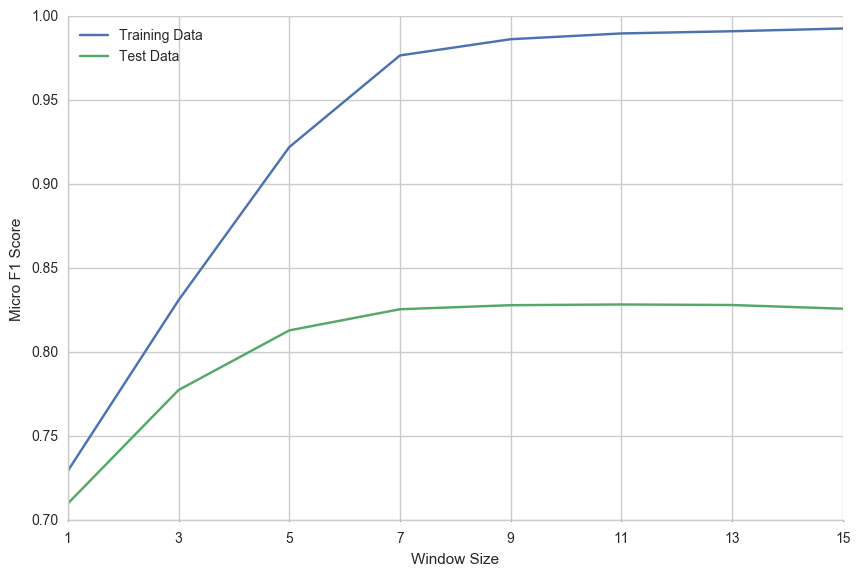

In [120]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.merge(
    get_by_window_size(cb_td_df), 
    get_by_window_size(cb_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size')
ax1.set_ylabel('Micro F1 Score')

plt.xticks(np.arange(min(x), max(x)+2, 2.0))

sns.despine()
plt.show()

## Plot TD vs VD F1 Score For SC By Window Size

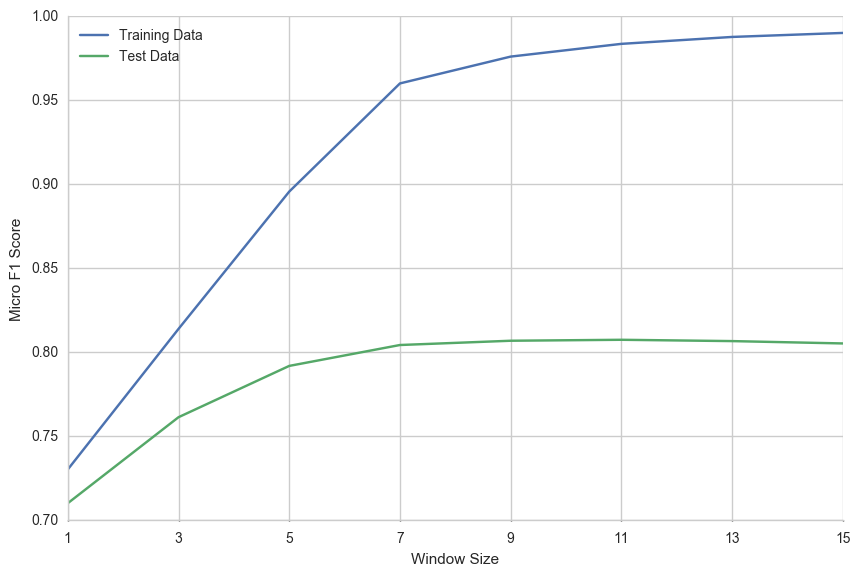

In [122]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.merge(
    get_by_window_size(sc_td_df), 
    get_by_window_size(sc_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size')
ax1.set_ylabel('Micro F1 Score')

plt.xticks(np.arange(min(x), max(x)+2, 2.0))

sns.despine()
plt.show()

## Performance By Feature Set Size

In [11]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count")

,count,max(micro_f1_score)_x,mean(micro_f1_score)_x,max(micro_f1_score)_y,mean(micro_f1_score)_y
0,1,0.817206,0.565948,0.799380,0.558362
1,2,0.823682,0.793374,0.804093,0.776986
2,3,0.826363,0.803536,0.806546,0.785991
3,4,0.827305,0.808519,0.806762,0.789886
4,5,0.827714,0.811045,0.807117,0.792022
5,6,0.828318,0.812727,0.807294,0.793117


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [12]:
cols_filter = "count,feats,micro_f1_score,window_size".split(",")

def get_f1_by_feat_count(df):
    top_feats = df.iloc[0]["feats"]

    rows = []
    for i in range(0,6):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        rows.append(new_row)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

cb_vd_df_f1_by_feat_count = get_f1_by_feat_count(cb_vd_df)
cb_vd_df_f1_by_feat_count

,count,feats,micro_f1_score,window_size
210,1,[fn_pos_wd_feats_stemmed[offset:5]],0.817206,11
117,2,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.822854,11
83,3,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.824505,11
17,4,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827008,11
7,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827558,11
0,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.828318,11


In [13]:
a = cb_vd_df_f1_by_feat_count["feats"].values
map(lambda l: ", ".join(l).replace("fn_", "").replace("offset:5","").replace(" ]","]").replace("feats","").replace("feat","").replace("__","_").replace("[]","")
    , a.tolist())

[u'pos_wd_stemmed',
 u'pos_wd_stemmed, pos_ngram_stemmed[ngram_size:3]',
 u'pos_wd_stemmed, pos_ngram_stemmed[ngram_size:3], bow_ngram_[ngram_size:1]',
 u'pos_wd_stemmed, pos_ngram_stemmed[ngram_size:3], bow_ngram_[ngram_size:1], pos_ngram_stemmed[ngram_size:2]',
 u'pos_wd_stemmed, pos_ngram_stemmed[ngram_size:3], bow_ngram_[ngram_size:1], pos_ngram_stemmed[ngram_size:2], extract_brown_cluster',
 u'pos_wd_stemmed, pos_ngram_stemmed[ngram_size:3], bow_ngram_[ngram_size:1], pos_ngram_stemmed[ngram_size:2], extract_brown_cluster, extract_dependency_relation']

## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [14]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"